In [133]:
from __future__ import print_function
import os
data_path = []

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#from sklearnex import patch_sklearn
#patch_sklearn()

import pandas as pd

# Import the data using the file path
filepath = os.sep.join(['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath)

#drop not-needed column
data.drop(['state', 'area_code', 'phone_number'], axis=1, inplace=True)

#cut off last column as category
x_cols = [x for x in data.columns if x != 'churned']

X_data = data[x_cols]
y_data = data['churned']

#transform string data to int
lb = LabelBinarizer()
for col in ['intl_plan', 'voice_mail_plan', 'churned']:
    data[col] = lb.fit_transform(data[col])
    
# Mute the sklearn warning
import warnings
warnings.filterwarnings('ignore', module='sklearn')

msc = MinMaxScaler()
ssc = StandardScaler()

data_msc = pd.DataFrame(msc.fit_transform(data),columns=data_msc.columns)
data_ssc = pd.DataFrame(ssc.fit_transform(data),columns=data_ssc.columns)


# Get a list of all the columns that don't contain the label
x_cols_msc = [x for x in data_msc.columns if x != 'churned']
x_cols_ssc = [x for x in data_ssc.columns if x != 'churned']

# Split the data into two dataframes
X_data_msc = data_msc[x_cols_msc]
y_data_msc = data_msc['churned']
X_data_ssc = data_ssc[x_cols_ssc]
y_data_ssc = data_ssc['churned']


def accuracy(real, predict):
    return sum(real == predict) / float(real.shape[0])


# 이제까지 data를 계산하기 좋게 처리를 하는 과정이었습니다.

In [106]:
def calculate_accuracy(scale, distance):
    score_list = list()
    
    if scale == 'minmax':
        X_data = X_data_msc
        Y_data = y_data_msc
    else:
        X_data = X_data_ssc
        Y_data = y_data_ssc
        
    for k in range(1,21):
        if distance == 'manhattan':
            knn = KNeighborsClassifier(n_neighbors=k, p=1)
        else : 
            knn = KNeighborsClassifier(n_neighbors=k, p=2)
        knn = knn.fit(X_data, y_data)

        y_pred = knn.predict(X_data)
        score = accuracy(y_data, y_pred)

        score_list.append((k, score))

    score_df = pd.DataFrame(score_list, columns=['k', 'accuracy'])
    return score_df


## 반복적으로 K-NN prediction을 해야 하므로 이를 함수로 만들어주었습니다.
### scale ==  'min_max' 일 경우 MinMaxScaler로 scale된 data, 
### 이외의 경우 StandardScaler로 scaling된 데이터를 사용합니다.
### distance == 'manhattan'일 경우 manhattan distance, 이외의 경우 euclidean distance를 사용합니다.

# (Q1) MinMaxScaler을 채택하고, Manhattan vs. Euclidean distances의 성능을 비교 분석하시오 (1점).

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

score_msc_manhattan = calculate_accuracy(scale='minmax', distance='manhattan')
score_msc_euclidean = calculate_accuracy(scale='minmax', distance='euclidean')

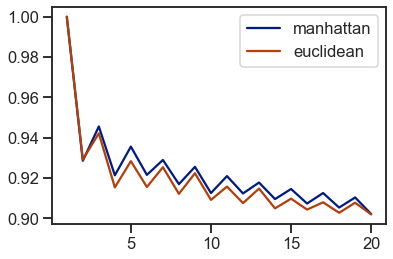

In [108]:
plt.plot(score_msc_manhattan['k'], score_msc_manhattan['accuracy'], 
         score_msc_euclidean['k'], score_msc_euclidean['accuracy'])
plt.legend(['manhattan', 'euclidean'])
plt.show()

두 distance 모두 k가 커질수록 정확도가 낮아지는 경향이 있습니다. K가 커질 수록 자신과 거리가 먼(다른) sample도 확인하므로 정확도가 낮아지는것으로 생각됩니다. K = 1일 떄 Manhattan, Euclidean 모두 정확도 1을 기록했습니다. 모두 가장 가까운 하나의 neighbore가 자신과 동일한 label을 가졌기 때문으로 보입니다. k = 0, k = 20일 때 외에는 Manhattan distance를 사용했을 때 정확도가 높은 모습을 보였습니다. 이유를 잘 모르겠어서 조사를 해본결과 데이터의 차원이 높을수록 모든 data의 Euclidean distance가 비슷해지므로 정확도가 떨어질 수 있다는 내용이 있었습니다. 현재 사용하고 있는 데이터는 column이 18개로 수업시간에 예시로 사용한 데이터보단 확실히 차원이 높습니다. 

# Q2) StandardScaler을 채택하고, Manhattan vs. Euclidean distances의 성능을 비교 분석하시오 (1점).

In [109]:
score_ssc_manhattan = calculate_accuracy(scale='standard', distance='manhattan')
score_ssc_euclidean = calculate_accuracy(scale='standard', distance='euclidean')

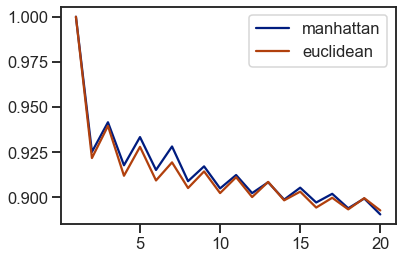

In [110]:
plt.plot(score_ssc_manhattan['k'], score_ssc_manhattan['accuracy'],
         score_ssc_euclidean['k'], score_ssc_euclidean['accuracy'])
plt.legend(['manhattan', 'euclidean'])
plt.show()

StandardScaler도 마찬가지로 K가 높아질수록 정확도는 감소하는 모습을 보였습니다. Q1에서 설명했던 것과 같은 이유 일 것으로 생각됩니다. MinMaxScaler와 다른점은 특정 manhattan 정확도와 euclidean 정확도 차이가 min_max 보다 작았습니다. 


In [120]:
import numpy as np
print('min_max사용시 accuracy 차이의 mean:   ', end="")
print(np.mean(score_msc_manhattan['accuracy'] - score_msc_euclidean['accuracy']))
print('standard사용시 accuracy 차이의 mean:  ', end="")
print(np.mean(score_ssc_manhattan['accuracy'] - score_ssc_euclidean['accuracy']))

min_max사용시 accuracy 차이의 mean:   0.0036199999999999843
standard사용시 accuracy 차이의 mean:  0.0024700000000000056


# (Q3) NN 알고리즘의 3가지 주요 고려사항(Scaling, Distances, K-values)에 대한 실험 결과를 분석(Empirical Evidences)하고, Reasoning을 제시하시오 (1점).

## Scale

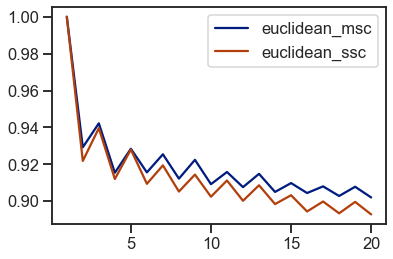

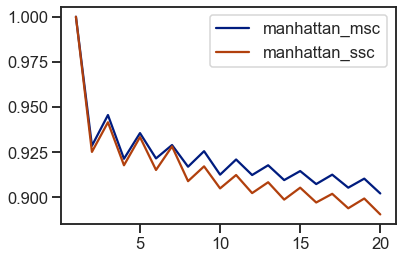

In [132]:
plt.plot(score_msc_euclidean['k'], score_msc_euclidean['accuracy'],
         score_ssc_euclidean['k'], score_ssc_euclidean['accuracy'])
plt.legend(['euclidean_msc', 'euclidean_ssc'])
plt.show()

plt.plot(score_msc_manhattan['k'], score_msc_manhattan['accuracy'], 
         score_ssc_manhattan['k'], score_ssc_manhattan['accuracy'], )
plt.legend(['manhattan_msc' ,'manhattan_ssc'])
plt.show()

Standard가 min_max보다 더 좋은 결과를 보여주었습니다. Standard가 min_max와 다른점 중 하나는 0~1보다 더 넓은 값을 가지도록 scale된다는 것입니다. 각 sample간 값의 최대 차이가 min_max의 경우 1이지만 standard의 경우 훨씬 큰 차이를 가질 수 있습니다. 값간 차이가 클 경우 확실히 distance의 차이가 나기 때문에 standardization이 더 좋은 결과를 보인다고 생각합니다.

## Distance

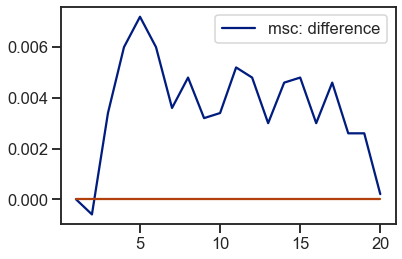

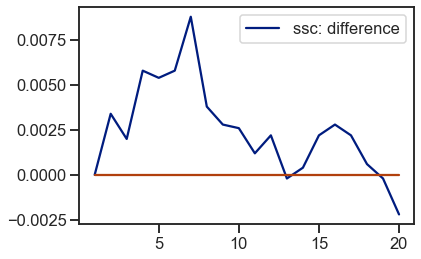

In [130]:
plt.plot(score_msc_manhattan['k'], score_msc_manhattan['accuracy'] - score_msc_euclidean['accuracy'],
        score_msc_manhattan['k'], [0 for i in range(20)])
plt.legend(['msc: difference'])
plt.show()

plt.plot(score_ssc_manhattan['k'], score_ssc_manhattan['accuracy'] - score_ssc_euclidean['accuracy'],
        score_msc_manhattan['k'], [0 for i in range(20)])    
plt.legend(['ssc: difference'])
plt.show()

다음 차트는 (manhattan으로 계산한 정확도) - (euclidean으로 계산한 정확도)를 나타낸 것입니다. 대부분의 경우 manhattan distance가 나은 정확도를 보였습니다. 이는 Q1에서 제시한 것과 같이 데이터의 차원이 높기 때문으로 생각됩니다. Euclidean distance의 경우 차원이 커질수록 대부분 유사한 거리를 가지게 되므로 정확도가 떨어진다고 합니다. 18차원이 이 이유로 정확도가 떨어질 만큼의 고차원인지는 확실하게 모르겠습니다.

## K-values

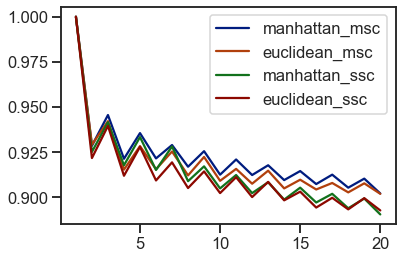

In [123]:
plt.plot(score_msc_manhattan['k'], score_msc_manhattan['accuracy'], 
         score_msc_euclidean['k'], score_msc_euclidean['accuracy'],
         score_ssc_manhattan['k'], score_ssc_manhattan['accuracy'], 
         score_ssc_euclidean['k'], score_ssc_euclidean['accuracy'])
plt.legend(['manhattan_msc', 'euclidean_msc', 'manhattan_ssc', 'euclidean_ssc'])
plt.show()

모든 경우에 K가 높아질 수록 정확도가 떨어지는 경향을 볼수 있었습니다. K가 커질수록 predict하려고 하는 데이터와 관련이 적은, distance가 큰 dataset까지 영향을 미치기 때문으로 보입니다.